In [ ]:
import netgen.gui
%gui tk 
# Netgen Graphical User Interface
from ngsolve import *
from netgen.geom2d import SplineGeometry
import numpy as np
from scipy import special
import scipy.linalg
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
import os.path
import sys
%load_ext autoreload
%autoreload 1
%aimport OpenScatteringSystems2d_funcs_v2
from OpenScatteringSystems2d_funcs_v2 import *

In [2]:
nphwl = 5  # nodes per half wavelength
feOrder = 3  # order of finite element polynomials between two nodes
pmlRad = 0.1 # radius of the region under consideration
lam = 0.025 # wavelength (lambda)
k = 2*np.pi/lam # wavevector

# Fix the number of modes by truncation
nOut = 0 # Number of output modes
while np.abs(sp.special.hankel1(nOut,k*pmlRad)) < 1e3: nOut += 1
nIn = nOut # Number of input modes
        
print('Number of modes = %d' %nIn)
print('Radius / lambda = %.1f' %(pmlRad/lam))
print('Circumference / lambda = %.1f' %(2*np.pi*pmlRad/lam))

shifts = np.array([-0.00825, 0.00825, 0.0])/100000.0  # transverse scatterer shifts

# Parameter dictionary to pass to functions
params = {'nphwl': nphwl, 
          'feOrder': feOrder,
          'k': k,
          'pmlRad': pmlRad,
          'nIn': nIn,
          'nOut': nOut,
          'mesh': None,
          'nrefr': None,
          'ainvGlobal': None}

Number of modes = 39
Radius / lambda = 4.0
Circumference / lambda = 25.1


# Empty Geometry

Create the scattering geometry

In [21]:
CreateGeometry(params, msgOutput=True)

 Generate Mesh from spline geometry
 HP Refinement called, levels = 3
MESH number of vertices = 11076
 Curve elements, order = 1
 Curve elements, order = 3


Plot the fundamental mode ($H_0$) and $H_5$

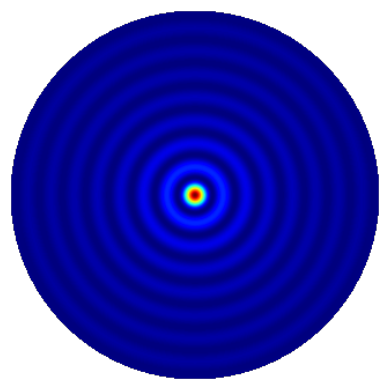

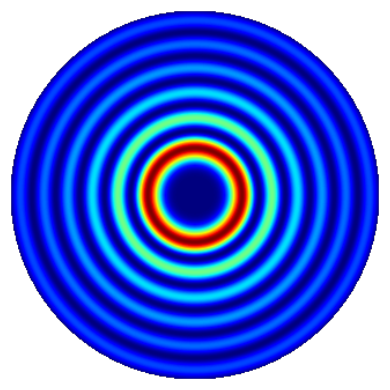

In [22]:
PlotStates(params, np.eye(2*nIn+1), [nIn, nIn+5], widthInches=4)

Compute the scattering matrix

In [23]:
S = CalcSMat(params)

Check that the scattering matrix is unitary and transposition symmetric

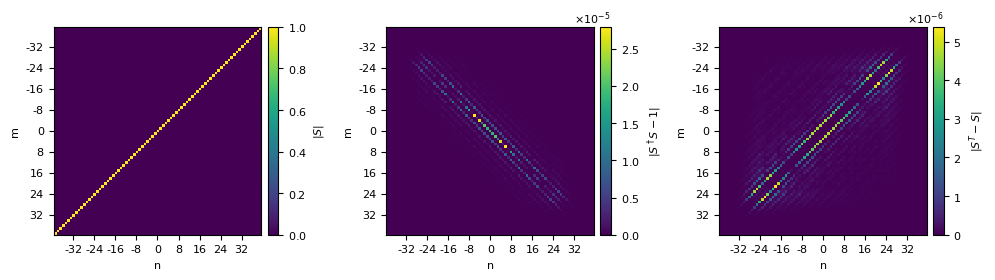

In [24]:
plt.rcdefaults()
plt.rcParams.update({'font.size': 8})

widthInches = 5

fig, axs = plt.subplots(1, 3, figsize=(2*widthInches,widthInches))

im = axs[0].imshow(np.abs(S), interpolation='None')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im, cax=cax, label=r'$|S|$')
cax.ticklabel_format(useMathText=True)

im = axs[1].imshow(np.abs(S.conj().T@S-np.eye(2*nIn+1)), interpolation='None')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im, cax=cax, label=r'$|S^\dagger S - 1|$')
cax.ticklabel_format(useMathText=True)

im = axs[2].imshow(np.abs(S.T - S), interpolation='None')
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im, cax=cax, label=r'$|S^T - S|$')
cax.ticklabel_format(useMathText=True)

for i in range(3):
    axs[i].set_xticks(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8)))) 
    axs[i].set_xticklabels(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8))) - nIn)
    axs[i].set_yticks(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8)))) 
    axs[i].set_yticklabels(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8))) - nIn)
    axs[i].set_xlabel('n')
    axs[i].set_ylabel('m', rotation=90)
    
plt.tight_layout()
plt.show()

Solve the system

In [25]:
sols = Solve(params, np.eye(2*nIn+1)[:,[nIn,nIn+5]]) # Solves the system for the incoming states H_0 and H_5

FES degrees of freedom = 98644
Using stored inverted system matrix ...


In [26]:
# Points on which to read out the wavefunction
rs = np.linspace(0,pmlRad,200)
phis = np.linspace(0,np.pi/2,7)

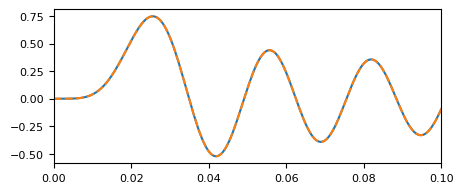

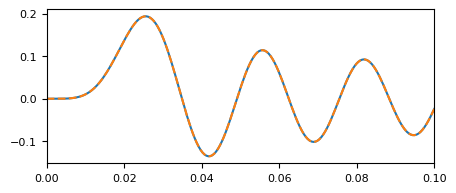

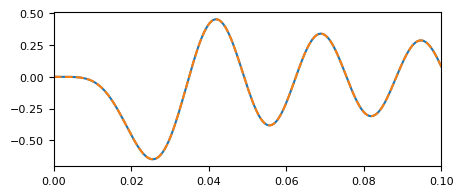

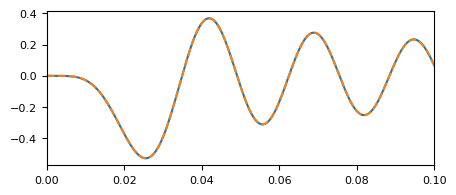

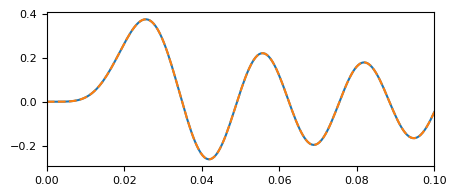

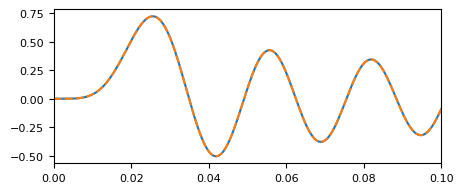

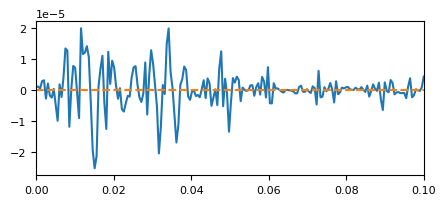

In [28]:
for i in range(len(phis)):
    psi = np.array([sols[1](params['mesh'](r*np.cos(phis[i]),r*np.sin(phis[i]))) for r in rs]) # Read out the solution on a line
    plt.figure(figsize=(5,2))
    plt.plot(rs, np.real(psi))
    plt.plot(rs, 2*sp.special.jn(5,k*rs)*np.real(np.exp(5.j*phis[i])), '--') # Analytical solution
    plt.xlim(0,pmlRad)
    plt.show()

# One scatterer

In [29]:
scatPos = np.array([[pmlRad/2], [0]]) # Position of the scatterer
scatRad = np.array([0.00825]) # Radius of the scatterer
scatNr = np.array([1e6]) # refractive index of the scatterer, anything over 1e3 is treated as Dirichlet bc
scatShape = ['circ'] # Shape of the scatterer (in this case a circle)

In [30]:
CreateGeometry(params, scatShape=scatShape, scatPos=scatPos, scatRad=scatRad, scatNr=scatNr, msgOutput=False)

 Generate Mesh from spline geometry
 HP Refinement called, levels = 3
 Curve elements, order = 1
 Curve elements, order = 3


In [31]:
S = CalcSMat(params)

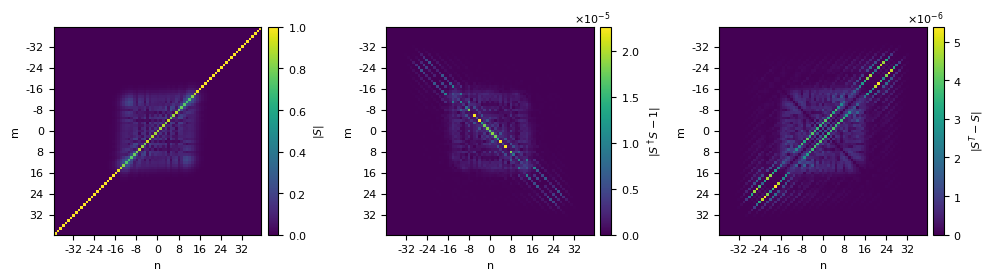

In [32]:
plt.rcdefaults()
plt.rcParams.update({'font.size': 8})

widthInches = 5

fig, axs = plt.subplots(1, 3, figsize=(2*widthInches,widthInches))

im = axs[0].imshow(np.abs(S), interpolation='None')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im, cax=cax, label=r'$|S|$')
cax.ticklabel_format(useMathText=True)

im = axs[1].imshow(np.abs(S.conj().T@S-np.eye(2*nIn+1)), interpolation='None')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im, cax=cax, label=r'$|S^\dagger S - 1|$')
cax.ticklabel_format(useMathText=True)

im = axs[2].imshow(np.abs(S.T - S), interpolation='None')
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im, cax=cax, label=r'$|S^T - S|$')
cax.ticklabel_format(useMathText=True)

for i in range(3):
    axs[i].set_xticks(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8)))) 
    axs[i].set_xticklabels(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8))) - nIn)
    axs[i].set_yticks(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8)))) 
    axs[i].set_yticklabels(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8))) - nIn)
    axs[i].set_xlabel('n')
    axs[i].set_ylabel('m', rotation=90)
    
plt.tight_layout()
plt.show()

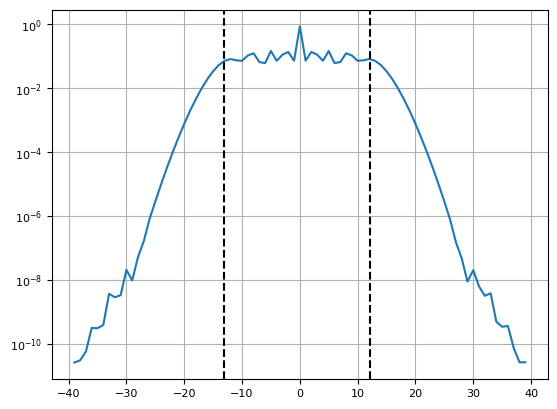

In [33]:
plt.plot(np.arange(-nIn,nIn+1), np.abs(S[nIn,:]))
plt.axvline(1/2*(np.sqrt((k*pmlRad)**2+1) - 1), c='k', ls='--')
plt.axvline(1/2*(-np.sqrt((k*pmlRad)**2+1) - 1), c='k', ls='--')
plt.yscale('log')
plt.grid()

# Random medium

In [34]:
scatPos, scatRad = DrawRandPositions(params, 0.00825, numScat=20, radMax=0.8*pmlRad)
# Find random positions for 20 scatterers with radius 0.00825 and maximum radial distance to the center of 0.8*pmlRad
scatNr = 1.44*np.ones(len(scatRad))

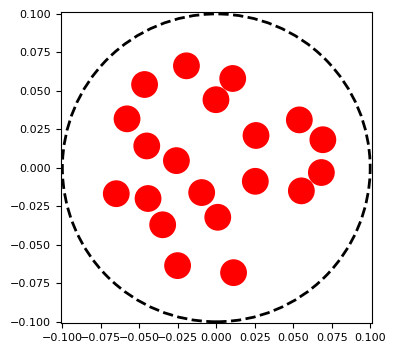

In [35]:
PlotScatteringConfiguration(params, scatPos, scatRad, widthInches=4, showAxis=True)

In [36]:
CreateGeometry(params, scatPos=scatPos, scatRad=scatRad, scatNr=scatNr, msgOutput=False)

 Generate Mesh from spline geometry
 HP Refinement called, levels = 3
 Curve elements, order = 1
 Curve elements, order = 3


In [37]:
S = CalcSMat(params)

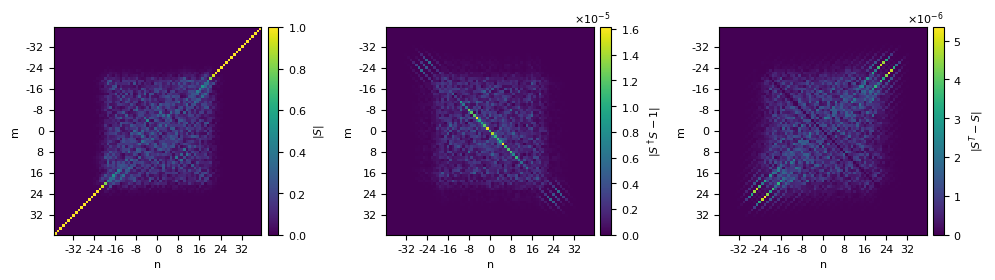

In [38]:
plt.rcdefaults()
plt.rcParams.update({'font.size': 8})

widthInches = 5

fig, axs = plt.subplots(1, 3, figsize=(2*widthInches,widthInches))

im = axs[0].imshow(np.abs(S), interpolation='None')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im, cax=cax, label=r'$|S|$')
cax.ticklabel_format(useMathText=True)

im = axs[1].imshow(np.abs(S.conj().T@S-np.eye(2*nIn+1)), interpolation='None')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im, cax=cax, label=r'$|S^\dagger S - 1|$')
cax.ticklabel_format(useMathText=True)

im = axs[2].imshow(np.abs(S.T - S), interpolation='None')
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im, cax=cax, label=r'$|S^T - S|$')
cax.ticklabel_format(useMathText=True)

for i in range(3):
    axs[i].set_xticks(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8)))) 
    axs[i].set_xticklabels(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8))) - nIn)
    axs[i].set_yticks(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8)))) 
    axs[i].set_yticklabels(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8))) - nIn)
    axs[i].set_xlabel('n')
    axs[i].set_ylabel('m', rotation=90)
    
plt.tight_layout()
plt.show()

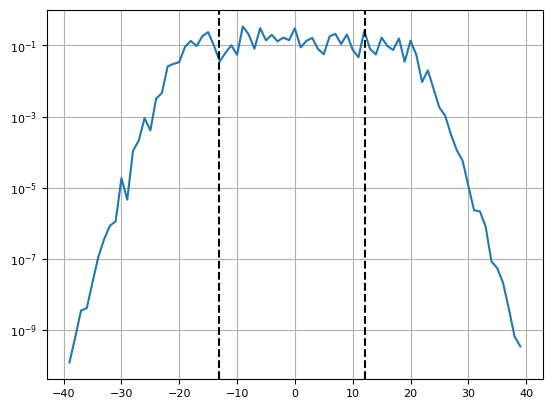

In [39]:
plt.plot(np.arange(-nIn,nIn+1), np.abs(S[nIn,:]))
plt.axvline(1/2*(np.sqrt((k*pmlRad)**2+1) - 1), c='k', ls='--')
plt.axvline(1/2*(-np.sqrt((k*pmlRad)**2+1) - 1), c='k', ls='--')
plt.yscale('log')
plt.grid()

# Force, metallic circle

In [156]:
scatPos = np.array([[pmlRad/2], [0]])
scatRad = np.array([0.00825])
scatNr = np.array([1e6])
scatShape = ['circ']

In [157]:
CreateGeometry(params, scatShape=scatShape, scatPos=scatPos, scatRad=scatRad, scatNr=scatNr, msgOutput=False)
S = CalcSMat(params, msgOutput=False)

 Generate Mesh from spline geometry
 HP Refinement called, levels = 3
 Curve elements, order = 1
 Curve elements, order = 3


Fix the solid angle through which waves can enter the system

In [158]:
angle = np.pi/2

Number of entries in the S matrix and GWS operator that are relevant for a giveen solid angle
An entry with an index above lowCut or below highCut is set to zero

In [159]:
lowCut = int(nIn//(2*np.pi/angle) + 1)
highCut = int(2*nIn-nIn//(2*np.pi/angle))

Compute the GWS operator

In [160]:
Qxevals, Qxcoefs, Qx = CalcGWSOperator(params, S, 0, sort='abs', deriv=False, restrict=True, angle=angle)
Qxevals = np.real(Qxevals[:lowCut+2*nIn+1-highCut]) # Remove all entries equal to zero

Compute the forces acting on the target for all eigenstates of the GWS operator

In [161]:
pphwl = 20
npts = int(ceil(2*scatRad[0]*k*pphwl))
F = CalcForce(params, Qxcoefs, range(lowCut+2*nIn+1-highCut), scatPos[:,0], npts, scatRad=scatRad[0], 
              scatShape='circle', d=1e-4)
Fx = F[:,0]

Check that they are in a linear relationship with the eigenvalues of $Q_x$

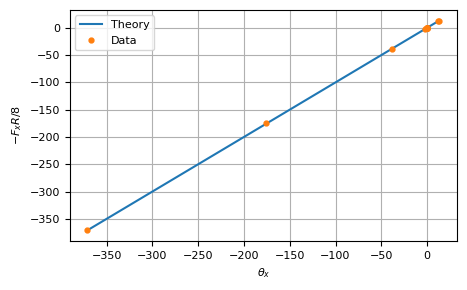

R = 0.9999970
Fit:      0.9975 x + 0.0259
Analytic: 1.0000 x 
F_push_theory / F_push_sim = 1.001
F_pull_theory / F_pull_sim = 1.014


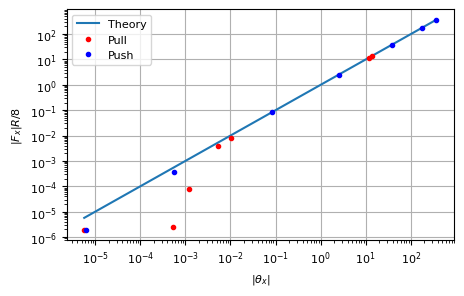

In [162]:
z = np.polyfit(Qxevals, -scatRad[0]*Fx/8, 1)
p = np.poly1d(z)

plt.figure(figsize=(5,3))
plt.plot(np.sort(Qxevals), np.sort(Qxevals), label='Theory')
plt.plot(Qxevals, -scatRad[0]*Fx/8, '.', label='Data', ms=7)
plt.xlabel(r'$\theta_x$')
plt.ylabel(r'$-F_x R / 8$')
plt.legend()
plt.grid()
plt.show()

print('R = %.7f' %np.corrcoef(Qxevals, -scatRad[0]*Fx/8)[0,1])
print('Fit:      %.4f x + %.4f'%(z[0], z[1]))
print('Analytic: %.4f x ' %(1))
print('F_push_theory / F_push_sim = %.3f' %(Qxevals[np.argmin(Qxevals)]/(-scatRad[0]*Fx[np.argmin(Qxevals)]/8)))
print('F_pull_theory / F_pull_sim = %.3f' %(Qxevals[np.argmax(Qxevals)]/(-scatRad[0]*Fx[np.argmax(Qxevals)]/8)))

plt.figure(figsize=(5,3))
plt.plot(np.sort(np.abs(Qxevals)), np.sort(np.abs(Qxevals)), label='Theory')
plt.plot(Qxevals[Qxevals>0], -scatRad[0]*Fx[Qxevals>0]/8, '.', c='r', label='Pull')
plt.plot(-Qxevals[Qxevals<0], scatRad[0]*Fx[Qxevals<0]/8, '.', c='b', label='Push')
plt.xlabel(r'$|\theta_x|$')
plt.ylabel(r'$|F_x| R / 8$')
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1,1e3)
#plt.xlim(1,1e3)
plt.legend()
plt.grid()
plt.show()

# Force, metallic triangle

In [172]:
scatPos = np.array([[pmlRad/2], [0]])
polyPts = np.array([[-lam, 0, 0], [0, -lam/2, lam/2]]) # coordinates of the triangle's corners relative to scatPos
scatNr = np.array([1e6])
scatShape = ['poly']

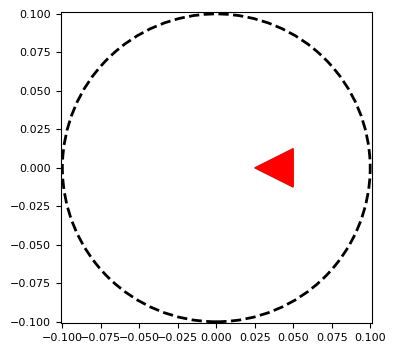

In [173]:
PlotScatteringConfiguration(params, scatPos, scatRad, scatShape=scatShape, polyPts=polyPts, widthInches=4)

In [174]:
CreateGeometry(params, scatPos=scatPos, scatNr=scatNr, scatShape=scatShape, polyPts=polyPts, msgOutput=False)
S = CalcSMat(params, msgOutput=False)

 Generate Mesh from spline geometry
 HP Refinement called, levels = 3
 Curve elements, order = 1
 Curve elements, order = 3


In [175]:
Qxevals, Qxcoefs, Qx = CalcGWSOperator(params, S, 0, sort='abs', deriv=False, restrict=True, angle=angle)
Qxevals = np.real(Qxevals[:lowCut+2*nIn+1-highCut])

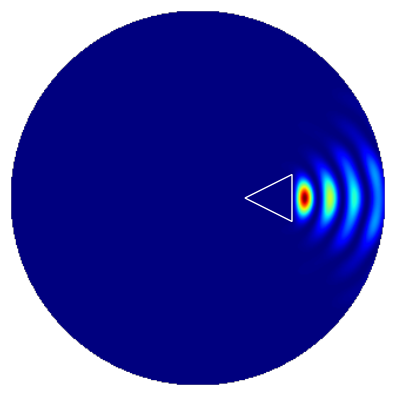

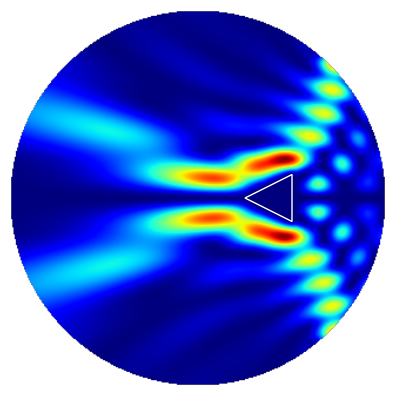

In [176]:
PlotStates(params, Qxcoefs, [np.argmin(Qxevals),np.argmax(Qxevals)], scatPos=scatPos, scatShape=scatShape, 
           polyPts=polyPts, widthInches=4)

In [177]:
F = CalcForce(params, Qxcoefs, range(lowCut+2*nIn+1-highCut), scatPos[:,0], 100, polyPts=polyPts, scatShape='poly', 
              d=1e-8)
Fx = F[:,0]

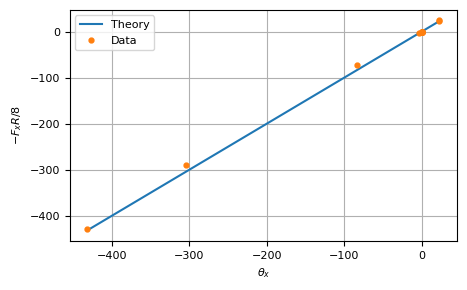

R = 0.9996459
Fit:      0.9782 x + 0.7767
Analytic: 1.0000 x 
F_push_theory / F_push_sim = 1.008
F_pull_theory / F_pull_sim = 0.944


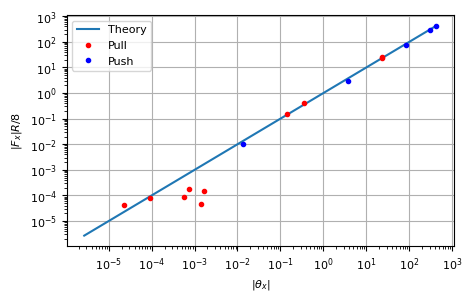

In [178]:
z = np.polyfit(Qxevals, -Fx/8, 1)
p = np.poly1d(z)

plt.figure(figsize=(5,3))
plt.plot(np.sort(Qxevals), np.sort(Qxevals), label='Theory')
plt.plot(Qxevals, -Fx/8, '.', label='Data', ms=7)
plt.xlabel(r'$\theta_x$')
plt.ylabel(r'$-F_x R / 8$')
plt.legend()
plt.grid()
plt.show()

print('R = %.7f' %np.corrcoef(Qxevals, -Fx/8)[0,1])
print('Fit:      %.4f x + %.4f'%(z[0], z[1]))
print('Analytic: %.4f x ' %(1))
print('F_push_theory / F_push_sim = %.3f' %(Qxevals[np.argmin(Qxevals)]/(-Fx[np.argmin(Qxevals)]/8)))
print('F_pull_theory / F_pull_sim = %.3f' %(Qxevals[np.argmax(Qxevals)]/(-Fx[np.argmax(Qxevals)]/8)))

plt.figure(figsize=(5,3))
plt.plot(np.sort(np.abs(Qxevals)), np.sort(np.abs(Qxevals)), label='Theory')
plt.plot(Qxevals[Qxevals>0], -Fx[Qxevals>0]/8, '.', c='r', label='Pull')
plt.plot(-Qxevals[Qxevals<0], Fx[Qxevals<0]/8, '.', c='b', label='Push')
plt.xlabel(r'$|\theta_x|$')
plt.ylabel(r'$|F_x| R / 8$')
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1,1e3)
#plt.xlim(1,1e3)
plt.legend()
plt.grid()
plt.show()

# Force, metallic rectangle

In [179]:
scatPos = np.array([[pmlRad/2], [0]])
polyPts = np.array([[0,-lam, -lam, 0], [lam, lam, -lam, -lam]]) 
scatNr = np.array([1e6])
scatShape = ['poly']

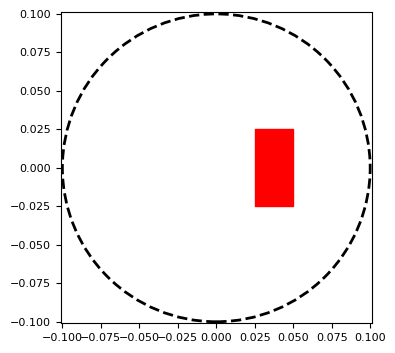

In [180]:
PlotScatteringConfiguration(params, scatPos, 0, scatShape=scatShape, polyPts=polyPts, widthInches=4)

In [181]:
CreateGeometry(params, scatPos=scatPos, scatNr=scatNr, scatShape=scatShape, polyPts=polyPts, msgOutput=False)
S = CalcSMat(params, msgOutput=False)

 Generate Mesh from spline geometry
 HP Refinement called, levels = 3
 Curve elements, order = 1
 Curve elements, order = 3


In [182]:
angle = np.pi/2
lowCut = int(nIn//(2*np.pi/angle) + 1)
highCut = int(2*nIn-nIn//(2*np.pi/angle))

In [183]:
Qxevals, Qxcoefs, Qx = CalcGWSOperator(params, S, 0, sort='abs', deriv=False, restrict=True, angle=angle)
Qxevals = np.real(Qxevals[:lowCut+2*nIn+1-highCut])

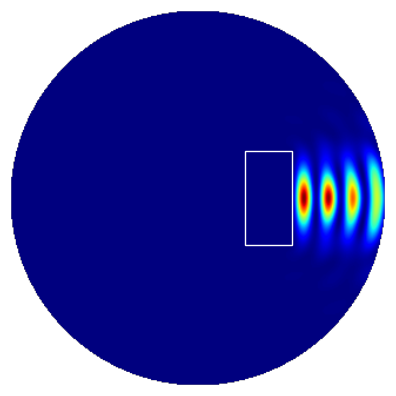

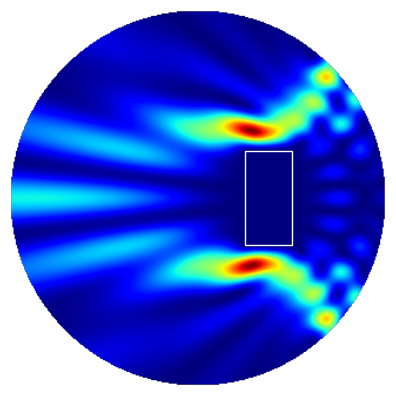

In [185]:
PlotStates(params, Qxcoefs, [np.argmin(Qxevals),np.argmax(Qxevals)], scatPos=scatPos, scatShape=scatShape, 
           polyPts=polyPts, widthInches=4)

In [186]:
F = CalcForce(params, Qxcoefs, range(lowCut+2*nIn+1-highCut), scatPos[:,0], 100, polyPts=polyPts, scatShape='poly', 
              d=1e-8)
Fx = F[:,0]

In [187]:
print([np.amin(Qxevals), np.amax(Qxevals)])
print(-Fx[[np.argmin(Qxevals), np.argmax(Qxevals)]]/8)

[np.float64(-454.04182256320684), np.float64(4.5185314719167256)]
[-453.45234088    4.26550896]


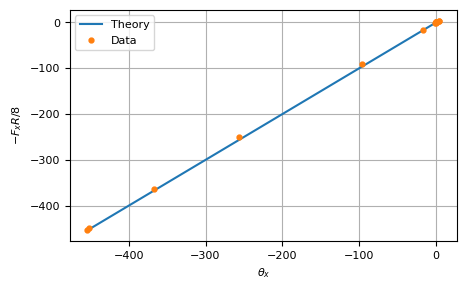

R = 0.9999349
Fit:      0.9928 x + 0.3955
Analytic: 1.0000 x 
F_push_theory / F_push_sim = 1.001
F_pull_theory / F_pull_sim = 1.059


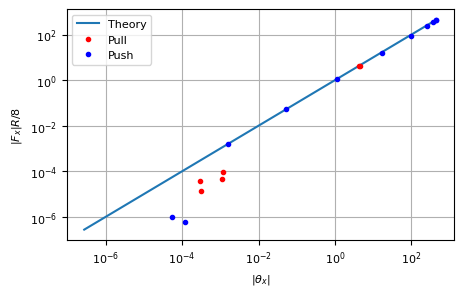

In [188]:
z = np.polyfit(Qxevals, -Fx/8, 1)
p = np.poly1d(z)

plt.figure(figsize=(5,3))
plt.plot(np.sort(Qxevals), np.sort(Qxevals), label='Theory')
plt.plot(Qxevals, -Fx/8, '.', label='Data', ms=7)
plt.xlabel(r'$\theta_x$')
plt.ylabel(r'$-F_x R / 8$')
plt.legend()
plt.grid()
plt.show()

print('R = %.7f' %np.corrcoef(Qxevals, -Fx/8)[0,1])
print('Fit:      %.4f x + %.4f'%(z[0], z[1]))
print('Analytic: %.4f x ' %(1))
print('F_push_theory / F_push_sim = %.3f' %(Qxevals[np.argmin(Qxevals)]/(-Fx[np.argmin(Qxevals)]/8)))
print('F_pull_theory / F_pull_sim = %.3f' %(Qxevals[np.argmax(Qxevals)]/(-Fx[np.argmax(Qxevals)]/8)))

plt.figure(figsize=(5,3))
plt.plot(np.sort(np.abs(Qxevals)), np.sort(np.abs(Qxevals)), label='Theory')
plt.plot(Qxevals[Qxevals>0], -Fx[Qxevals>0]/8, '.', c='r', label='Pull')
plt.plot(-Qxevals[Qxevals<0], Fx[Qxevals<0]/8, '.', c='b', label='Push')
plt.xlabel(r'$|\theta_x|$')
plt.ylabel(r'$|F_x| R / 8$')
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1,1e3)
#plt.xlim(1,1e3)
plt.legend()
plt.grid()
plt.show()

# Shift

Check that the scattering matrix of a target shifted by some amount can also be computed using an unitary translation operator

In [189]:
scatPos = np.array([[0], [0]])
scatRad = np.array([0.00825])
scatNr = np.array([1e6])
scatShape = ['circ']
shifts = np.linspace(0,pmlRad-2*scatRad[0],11)
print(shifts/lam)

[0.    0.334 0.668 1.002 1.336 1.67  2.004 2.338 2.672 3.006 3.34 ]


Compute the shifted scattering matrices by shifting the target

In [190]:
S = np.zeros((2*nOut+1,2*nIn+1,len(shifts)), dtype=complex)
for i in range(len(shifts)):
    CreateGeometry(params, scatShape=scatShape, scatPos=scatPos, scatRad=scatRad, scatNr=scatNr, msgOutput=False, 
                   shiftLong=shifts[i])
    S[:,:,i] = CalcSMat(params)
    print('%d/%d' %(i+1,len(shifts)), end='\r')

 Generate Mesh from spline geometry
 HP Refinement called, levels = 3
 Curve elements, order = 1
 Curve elements, order = 3
 Generate Mesh from spline geometry
 HP Refinement called, levels = 3
 Curve elements, order = 1
 Curve elements, order = 3
 Generate Mesh from spline geometry
 HP Refinement called, levels = 3
 Curve elements, order = 1
 Curve elements, order = 3
 Generate Mesh from spline geometry
 HP Refinement called, levels = 3
 Curve elements, order = 1
 Curve elements, order = 3
 Generate Mesh from spline geometry
 HP Refinement called, levels = 3
 Curve elements, order = 1
 Curve elements, order = 3
 Generate Mesh from spline geometry
 HP Refinement called, levels = 3
 Curve elements, order = 1
 Curve elements, order = 3
 Generate Mesh from spline geometry
 HP Refinement called, levels = 3
 Curve elements, order = 1
 Curve elements, order = 3
 Generate Mesh from spline geometry
 HP Refinement called, levels = 3
 Curve elements, order = 1
 Curve elements, order = 3
 Generat

In [191]:
kx = CalcKxInOperator(params) # Compute K_x^{in}

Compute the shifted (translated) scattering matrix by unitary transformation

In [192]:
S_trans = np.zeros((2*nOut+1,2*nIn+1,len(shifts)), dtype=complex)
for i in range(len(shifts)):
    S_trans[:,:,i] = sp.linalg.expm(-1.j*kx*shifts[i])@S[:,:,0]@sp.linalg.expm(1.j*kx*shifts[i])

Check that this gives the same result (up to numerical error)

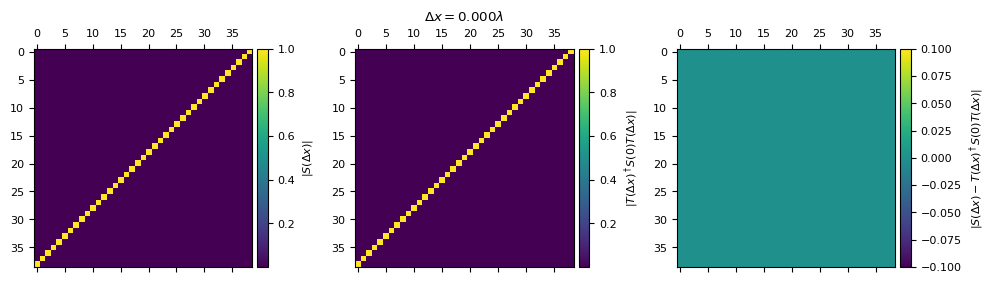

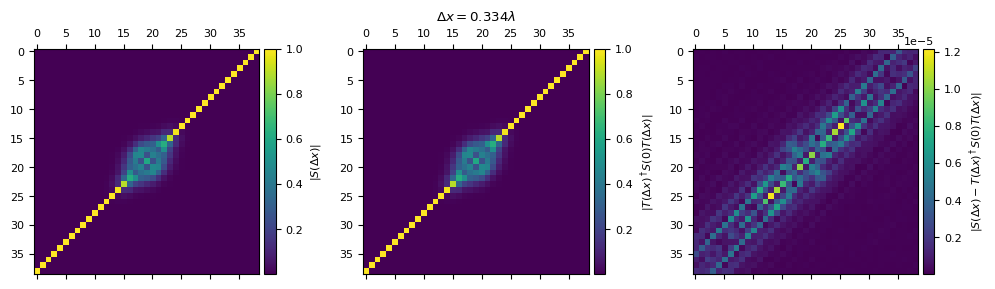

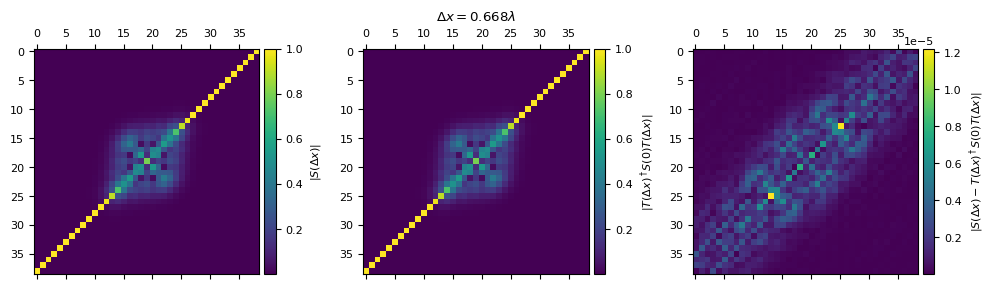

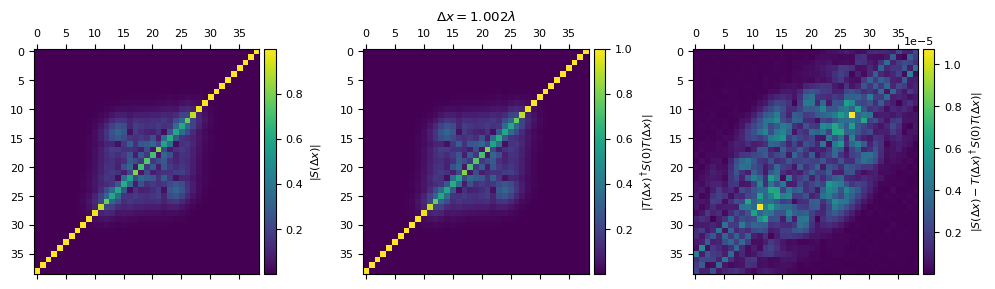

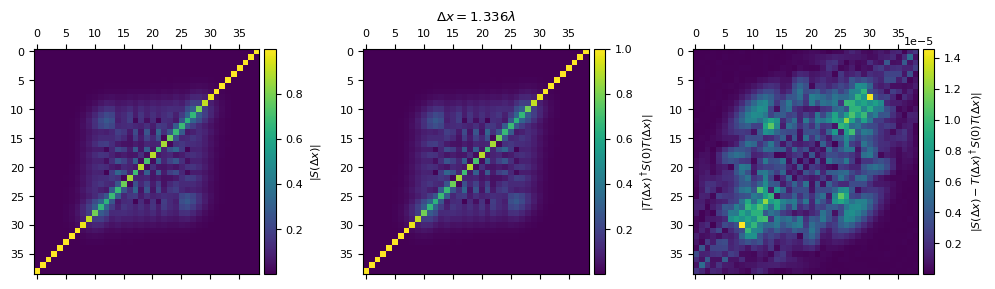

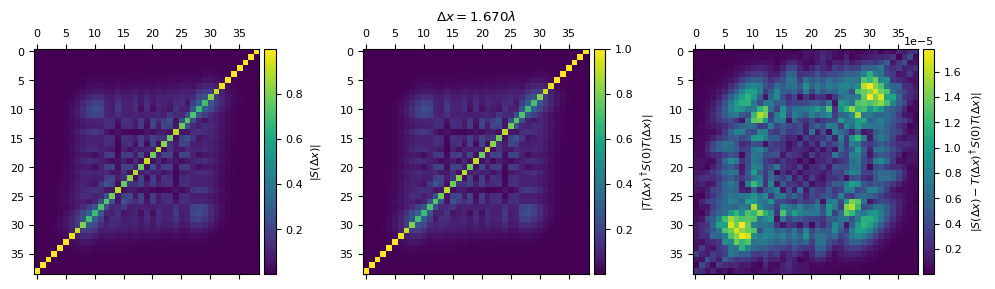

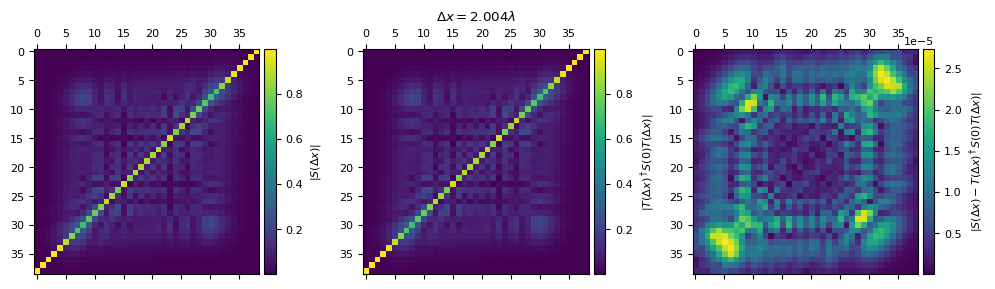

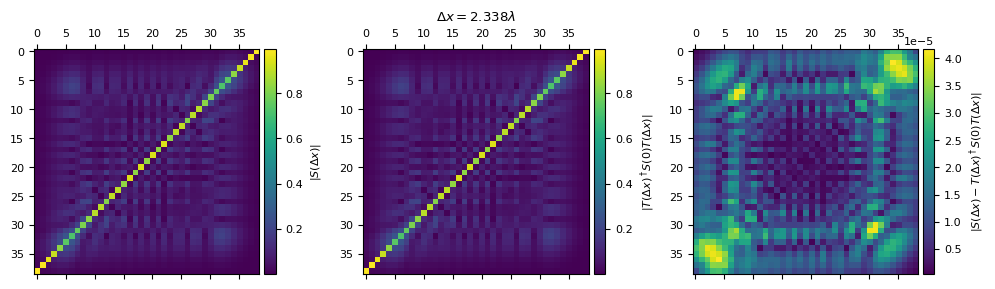

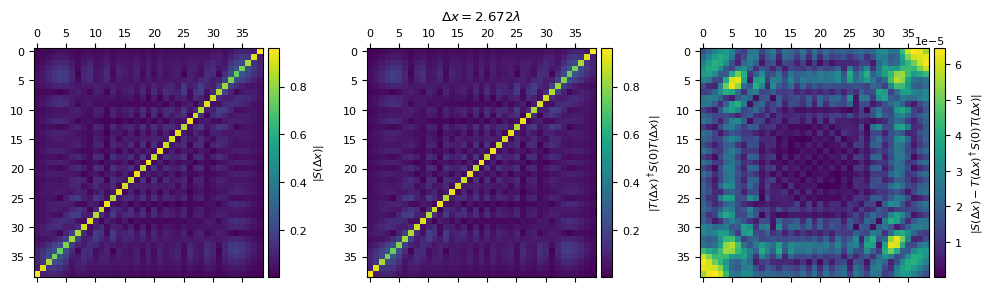

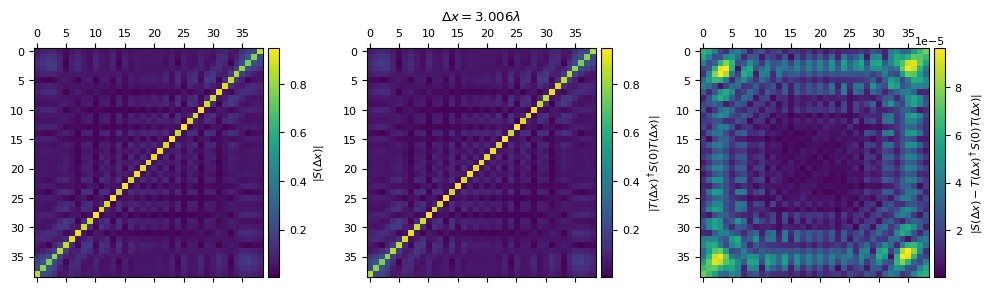

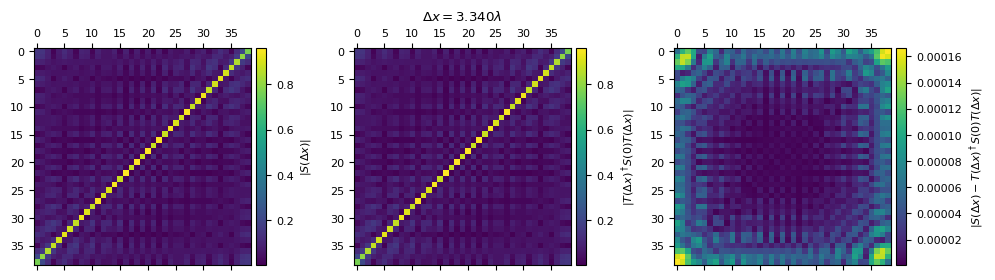

In [194]:
for i in range(len(shifts)):
    fig, ax = plt.subplots(ncols=3, figsize=(10,4))
    ax[1].set_title(r'$\Delta x = %.3f \lambda$' %(shifts[i]/lam))
    im1 = ax[0].matshow(np.abs(S[20:-20,20:-20,i]))
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical', label=r'$|S(\Delta x)|$')
    im2 = ax[1].matshow(np.abs(S_trans[20:-20,20:-20,i]))
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical', label=r'$|T(\Delta x)^\dagger S(0) T(\Delta x)|$')
    im3 = ax[2].matshow(np.abs(S[20:-20,20:-20,i]-S_trans[20:-20,20:-20,i]))
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical', label=r'$|S(\Delta x)-T(\Delta x)^\dagger S(0) T(\Delta x)|$')
    plt.tight_layout()
    plt.show()

# Inverse Design

In [53]:
sqphwl = 51
width = 0.02
print(width/lam)
ROI = np.array([width,width])
ROICenter = np.array([pmlRad/2,0.0])

dyRes = (2*np.pi/np.real(k))/2.0/float(sqphwl)
dxRes = dyRes
Ny = int(np.ceil(ROI[1]/dyRes))
Nx = int(np.ceil(ROI[0]/dxRes))
dxRes = ROI[0]/Nx
dyRes = ROI[1]/Ny
xs = np.linspace(ROICenter[0]-ROI[0]/2+ROI[0]/Nx/2, ROICenter[0]+ROI[0]/2-ROI[0]/Nx/2, num=Nx)
ys = np.linspace(ROICenter[1]-ROI[1]/2+ROI[1]/Ny/2, ROICenter[1]+ROI[1]/2-ROI[1]/Ny/2, num=Ny)

print(Nx, Ny)

nMin = 1.
nMax = 3.
pixNr = nMax*np.ones(Nx*Ny)

scatShape = ['poly']
polyPts = 0.5*np.array([[ROI[0], ROI[0], -ROI[0], -ROI[0]], [-ROI[1], ROI[1], ROI[1], -ROI[1]]])

0.7999999999999999
82 82


In [54]:
CreateMesh(params, sqphwl=sqphwl, ROI=ROI, ROICenter=ROICenter, pixNr=pixNr, msgOutput=False)

 Generate Mesh from spline geometry
 HP Refinement called, levels = 3
 Curve elements, order = 1
 Curve elements, order = 3


In [55]:
Draw(params['nrefr'], params['mesh'], 'n')

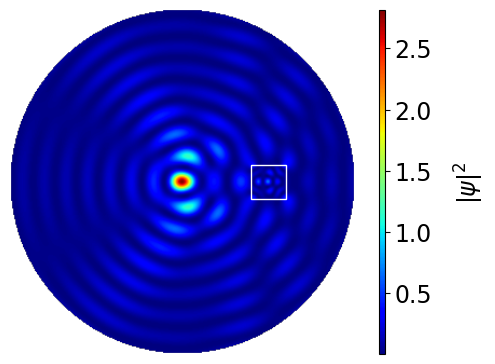

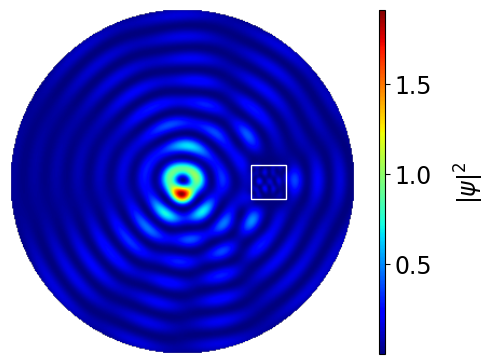

In [56]:
PlotStates(params, np.eye(2*nIn+1), np.array([nIn,nIn+1]), scatPos=ROICenter.reshape(2,1), scatRad=np.array([ROI[0]/2]), 
           scatShape=scatShape, polyPts=polyPts, widthInches=5, colorBar=True, colorBarLabel=True, colorBarTicks=True)

In [57]:
S = CalcSMat(params)

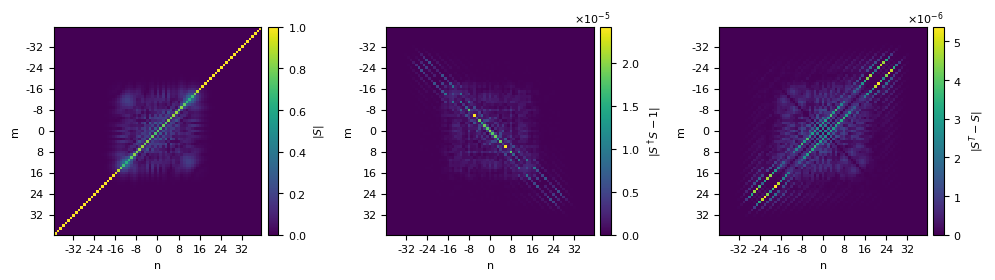

In [58]:
plt.rcdefaults()
plt.rcParams.update({'font.size': 8})

widthInches = 5

fig, axs = plt.subplots(1, 3, figsize=(2*widthInches,widthInches))

im = axs[0].imshow(np.abs(S), interpolation='None')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im, cax=cax, label=r'$|S|$')
cax.ticklabel_format(useMathText=True)

im = axs[1].imshow(np.abs(S.conj().T@S-np.eye(2*nIn+1)), interpolation='None')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im, cax=cax, label=r'$|S^\dagger S - 1|$')
cax.ticklabel_format(useMathText=True)

im = axs[2].imshow(np.abs(S.T - S), interpolation='None')
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im, cax=cax, label=r'$|S^T - S|$')
cax.ticklabel_format(useMathText=True)

for i in range(3):
    axs[i].set_xticks(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8)))) 
    axs[i].set_xticklabels(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8))) - nIn)
    axs[i].set_yticks(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8)))) 
    axs[i].set_yticklabels(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8))) - nIn)
    axs[i].set_xlabel('n')
    axs[i].set_ylabel('m', rotation=90)
    
plt.tight_layout()
plt.show()

In [59]:
angle = np.pi/2
lowCut = int(nIn//(2*np.pi/angle) + 1)
highCut = int(2*nIn-nIn//(2*np.pi/angle))

In [60]:
Qxevals, Qxcoefs, Qx = CalcGWSOperator(params, S, 0, sort='real', deriv=False, restrict=True, angle=angle)

In [61]:
print(np.real(Qxevals))

[ 2.98065315e+01  6.95444439e+00  5.49583724e-02  5.18981413e-02
  1.24970638e-03  1.16832876e-03  5.58807485e-04  4.77088964e-04
  1.47908150e-04  1.52897774e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

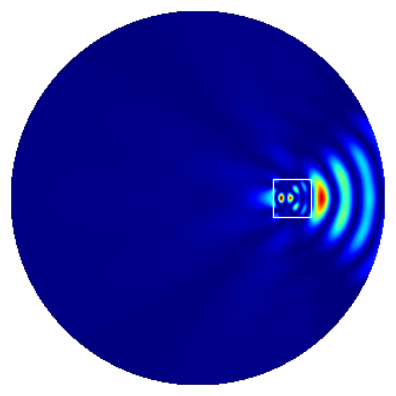

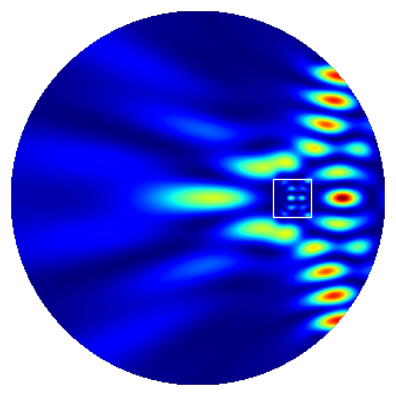

In [62]:
PlotStates(params, Qxcoefs, [np.argmin(Qxevals),np.argmax(Qxevals)], scatPos=ROICenter.reshape(2,1), scatShape=scatShape, 
           polyPts=polyPts, widthInches=4)

In [139]:
kIn = CalcKxInOperator(params)
phievals, phicoefs, _ = CalcPhiInOperator(params)

In [64]:
def f_and_df(scatNr):
    updateNrefr(params, scatNr)
    S = CalcSMat(params)
    Qxevals, Qxcoefs, Qx = CalcGWSOperator(params, S, 0, sort='real', deriv=False, restrict=True, angle=angle)
    print('%.5f' %np.real(Qxevals[0]))
    Qxcoefs = phicoefs.conj().T@Qxcoefs
    
    Qns = calcQsROI(params, ROI, ROICenter, sqphwl)

    dQxda = 1.0j*(Qns@S.conj().T@kIn@S - S.conj().T@kIn@S@Qns)
    dQxda = phicoefs.conj().T @ dQxda @ phicoefs
    dQxda[:,:,lowCut:highCut] = 0.
    dQxda[:,lowCut:highCut,:] = 0.

    daQxeval = Qxcoefs[:,0].conj().T@dQxda@Qxcoefs[:,0]

    return (np.real(Qxevals[0]), # objective function
            np.real(daQxeval)*k**2*scatNr*(xs[1]-xs[0])*(ys[1]-ys[0])) # gradient

In [69]:
f, df = f_and_df(pixNr)

29.80653


Text(0, 0.5, 'y (a.u.)')

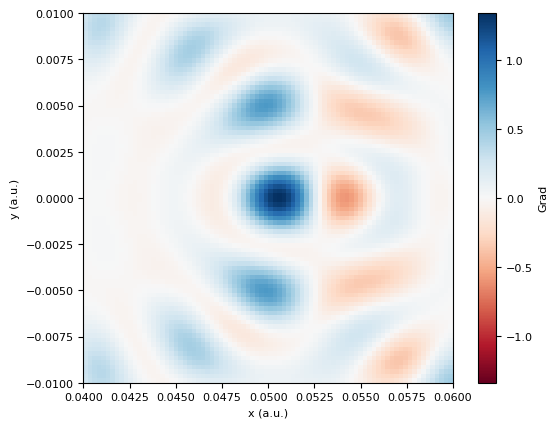

In [114]:
plt.pcolormesh(XX, YY, df.reshape(Nx,Ny).T, cmap='RdBu', norm=mpl.colors.CenteredNorm(vcenter=0))
plt.colorbar(label='Grad')
plt.gca().set_aspect('equal')
plt.xlabel('x (a.u.)')
plt.ylabel('y (a.u.)')

Text(0, 0.5, 'y (a.u.)')

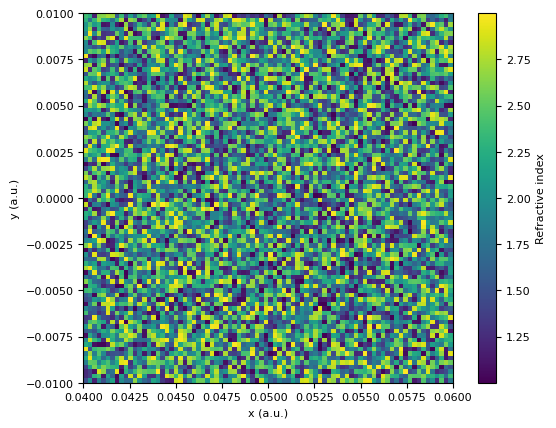

In [109]:
scatNr0 = (nMax - nMin)*np.random.rand(Nx*Ny) + nMin

plt.pcolormesh(XX, YY, scatNr0.reshape(Nx,Ny).T)
plt.colorbar(label='Refractive index')
plt.gca().set_aspect('equal')
plt.xlabel('x (a.u.)')
plt.ylabel('y (a.u.)')

In [73]:
bounds = [(nMin,nMax) for i in range(Nx*Ny)]

In [101]:
res = sp.optimize.minimize(f_and_df, scatNr0, method='L-BFGS-B', jac=True, bounds=bounds, 
                           options={'maxiter': 10, 'ftol': 1e-6})

31.44194
28.13322
10.44320
3.91037
2.40182
2.30352
1.35674
0.79661
0.64050
0.58779
0.45420


Text(0, 0.5, 'y (a.u.)')

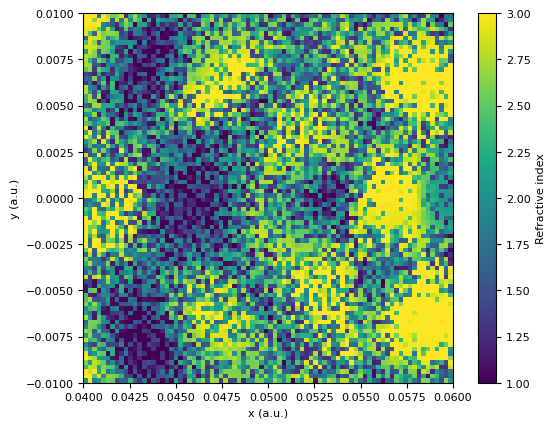

In [102]:
XX, YY = np.meshgrid(xs, ys)

plt.pcolormesh(XX, YY, res.x.reshape(Nx,Ny).T)
plt.colorbar(label='Refractive index')
plt.gca().set_aspect('equal')
plt.xlabel('x (a.u.)')
plt.ylabel('y (a.u.)')

In [103]:
updateNrefr(params, res.x)

In [117]:
Draw(params['nrefr'], params['mesh'], 'n')

In [105]:
S = CalcSMat(params)

In [106]:
Qxevals, Qxcoefs, Qx = CalcGWSOperator(params, S, 0, sort='real', deriv=False, restrict=True, angle=angle)

In [107]:
np.real(Qxevals)[np.real(Qxevals) != 0]

array([ 4.54203206e-01,  3.40381485e-01,  2.14579107e-02,  1.62365441e-03,
        1.15003334e-03,  5.34739525e-04,  4.14982248e-04,  1.71961879e-04,
        2.98705695e-07, -6.30442708e-06, -2.33542023e-05, -1.07843487e-04,
       -1.57338100e-04, -3.21437092e-03, -8.04970899e+00, -1.67156590e+01,
       -6.83896805e+01, -1.05580430e+02, -2.84190312e+02, -3.20210173e+02])

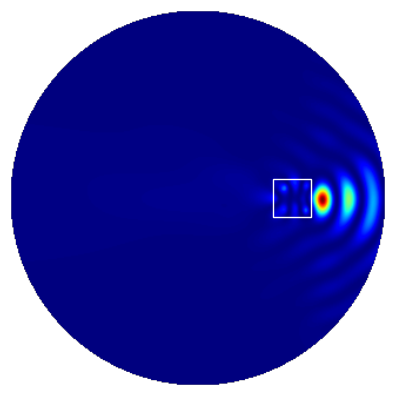

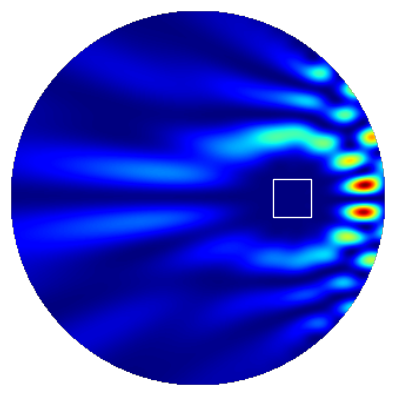

In [108]:
PlotStates(params, Qxcoefs, [np.argmin(Qxevals),np.argmax(Qxevals)], scatPos=ROICenter.reshape(2,1), scatShape=scatShape, 
           polyPts=polyPts, widthInches=4)